## Our objective is to:

- Utilize RFM analysis to segment customers based on their purchase recency, frequency, and monetary value, enabling targeted marketing efforts and personalized communication with customers.

- Develop predictive models to identify daily, weekly, and monthly sales trends, enabling better inventory management and more effective marketing campaigns.

- Use data analytics to identify the busiest hours of the day, week, or month, allowing for effective staff scheduling and resource allocation.

- Identify the top 20 best-selling items in the market, enabling businesses to focus on these high-performing products and optimize inventory and pricing strategies.

- Utilize RFM analysis with a higher weightage on monetary value to segment customers and identify high-value customers for targeted marketing campaigns and personalized communication.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
customer = pd.read_excel('Customer_Segment.xlsx')

In [3]:
data=customer.copy()

## Data Preprocessing

In [4]:
data.head()

,InvoiceNo,StockCode,lower,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart t-light holder,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart.,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
data.shape

(541909, 9)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   lower        1816 non-null    object        
 3   Description  540455 non-null  object        
 4   Quantity     541909 non-null  int64         
 5   InvoiceDate  541909 non-null  datetime64[ns]
 6   UnitPrice    541909 non-null  float64       
 7   CustomerID   406829 non-null  float64       
 8   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 37.2+ MB


***Notes:***
- Lower can be dropped. Most values are missing. Importantly same information is covered in Description column.
- Missing values in Description and Customer ID. We can check if there is any relation between StockCode and Description to fill this data. We cannot in any way impute Customer id. We will have to drop rows where Customer id is missing while performing customer segmentation

##### - Dropping columns with more than 60% of missing data.

In [7]:
data.drop('lower',axis=1,inplace=True)

##### - Checking for relation between Description and Stock code

In [8]:
(data[['Description','StockCode']][data['StockCode']=='84406B']).head(3)

,Description,StockCode
2,CREAM CUPID HEARTS COAT HANGER,84406B
51,CREAM CUPID HEARTS COAT HANGER,84406B
68,CREAM CUPID HEARTS COAT HANGER,84406B


In [9]:
(data[['Description','StockCode']][data['Description']=='WHITE HANGING HEART T-LIGHT HOLDER']).head(3)

,Description,StockCode
0,WHITE HANGING HEART T-LIGHT HOLDER,85123A
49,WHITE HANGING HEART T-LIGHT HOLDER,85123A
66,WHITE HANGING HEART T-LIGHT HOLDER,85123A


In [10]:
temp = data[['Description','StockCode']].dropna()

In [11]:
temp.StockCode.count()

540455

In [12]:
uni1 = temp['Description'].unique()
uni2 = temp['StockCode'].unique()

##### - Checking numerical values description

In [13]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


***Notes:***
- There are negative values in Quanitity column. These may be due to item returned. Since a returned item represents a null transaction. We will impute Zero wherever the quantity is negative.
- We can also observe minimun unit price of some item is negative. This maybe due to some error. 
- Maximun price of an item is 38970 dollars. It will be interesting to check this particular customer. How frequent this buyer is? How much per purchase on average he spends?
- 80995 quantities that unit seems a bit odd. This customer can be an outlier. Again it would be interesting to check average number and type of purchases this customer has made. 

##### - checking negative value in quantity column

In [14]:
data[data['Quantity']<0].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


As thought, these include discount, free gift or a returned item. Instead keeping these quanties as negative. Lets replace it with zero. So that they donot have inreverse impact drung total cost calculation.

In [15]:
data['Quantity'] = data['Quantity'].apply(lambda x: x if x>0 else 0)

In [16]:
data[data['Quantity']<0].count()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

##### - checking negative value in Unit price column

In [17]:
data[data['UnitPrice']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


We will drop these data points. As desciption suggest, these are adjustment in bad debts.

In [18]:
data.drop(index=data[data['UnitPrice']<0].index,inplace=True)

In [19]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541907.0,10.446403,155.292711,0.0,1.00,3.00,10.00,80995.0
UnitPrice,541907.0,4.651957,94.395447,0.0,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.0,13953.00,15152.00,16791.00,18287.0


Now, unit price is showing minimum value as zero.

In [20]:
data[data['UnitPrice']==0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,0.0,NaN,United Kingdom
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.0,NaN,United Kingdom
538554,581408,85175,NaN,20,2011-12-08 14:06:00,0.0,NaN,United Kingdom


These items will anyway nullify themselves during feature engineering. Many of them are also missing customer ID.

## Feature Engineering

We should do some feature engineering, merging columns like unit price and quantity. Later combining items inside a single invoice number and then grouping by customer id. 

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541907 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541907 non-null  object        
 1   StockCode    541907 non-null  object        
 2   Description  540453 non-null  object        
 3   Quantity     541907 non-null  int64         
 4   InvoiceDate  541907 non-null  datetime64[ns]
 5   UnitPrice    541907 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541907 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 37.2+ MB


In [22]:
data['Description'].isnull().sum()/len(data)

0.002683117213839275

- The missing values in Desciption column are negligible. We won't drop it now.
- In case of Customer ID er cannot impute Customer id. 
So whenever need arises we will drop these rows with missing values.

In [23]:
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


We can create a single Total Amt column by multiplying quantity with unit price

In [24]:
data['Total_Amt'] = data['Quantity']*data['UnitPrice']
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Amt
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [25]:
# Dropping Quantity and Unitprice column since they are represented by Total amt column now
data.drop(['Quantity','UnitPrice'],axis=1,inplace=True)

In [26]:
data.head(2)

,InvoiceNo,StockCode,Description,InvoiceDate,CustomerID,Country,Total_Amt
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,2010-12-01 08:26:00,17850.0,United Kingdom,20.34


In [27]:
data.nunique()

InvoiceNo      25898
StockCode       4070
Description     4223
InvoiceDate    23258
CustomerID      4372
Country           38
Total_Amt       4907
dtype: int64

# EDA

Lets do some basic EDA before proceeding with customer segregation

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541907 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541907 non-null  object        
 1   StockCode    541907 non-null  object        
 2   Description  540453 non-null  object        
 3   InvoiceDate  541907 non-null  datetime64[ns]
 4   CustomerID   406829 non-null  float64       
 5   Country      541907 non-null  object        
 6   Total_Amt    541907 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 33.1+ MB


In [29]:
for i in data.columns:
    print(f'Total number of unique values in {i} column are:',data[i].nunique())
    print('-----'*15)

Total number of unique values in InvoiceNo column are: 25898
---------------------------------------------------------------------------
Total number of unique values in StockCode column are: 4070
---------------------------------------------------------------------------
Total number of unique values in Description column are: 4223
---------------------------------------------------------------------------
Total number of unique values in InvoiceDate column are: 23258
---------------------------------------------------------------------------
Total number of unique values in CustomerID column are: 4372
---------------------------------------------------------------------------
Total number of unique values in Country column are: 38
---------------------------------------------------------------------------
Total number of unique values in Total_Amt column are: 4907
---------------------------------------------------------------------------


Out of this we will check the COuntry column values

In [30]:
len(data['Country'])

541907

In [31]:
(data['Country'].value_counts()/len(data['Country']))*100

United Kingdom          91.431925
Germany                  1.752146
France                   1.579053
EIRE                     1.512437
Spain                    0.467423
Netherlands              0.437529
Belgium                  0.381800
Switzerland              0.369436
Portugal                 0.280306
Australia                0.232328
Norway                   0.200403
Italy                    0.148180
Channel Islands          0.139876
Finland                  0.128251
Cyprus                   0.114780
Sweden                   0.085254
Unspecified              0.082302
Austria                  0.073998
Denmark                  0.071784
Japan                    0.066063
Poland                   0.062926
Israel                   0.054806
USA                      0.053699
Hong Kong                0.053146
Singapore                0.042258
Iceland                  0.033585
Canada                   0.027865
Greece                   0.026942
Malta                    0.023436
United Arab Em

- More than 90% of Customer data is from UK.
- So we can say that the data is biased and represent only particular part of the world. It would have been interesting to draw insights and check wheather their is substantial difference in behavior based on nationality.
- My hypothesis is there should be a difference. But sadly we donot have sufficient data of other countries to make check that claim.

##### I am thinking proceeding with the objective and carry out EDA towards the end when we have most of data properly organised and merged.

## Goal 1: Segregating Customers on basis of Recency, Frquency & Monetary

We will first group by invoice number then by customer id.

We will form two separate dataframes.
- One with Invoice number and Total amount. So we can sum up the Total amount.
- Second Invoice number, date and customer id. In this we will drop duplicate values of invoice number.
- Rest all columns which are not required we will drop,

Later we will segment customers based on their 
- ***Recency*** - Last data of purchase, 
- ***Frequency*** - No. of times purchase is made 
- ***Monetary***  - Total amount spent by customer.

We will segement customer into different classes and target different schemes to reduce customer losing rate.

Since we are starting with customer segmentation it will be better to drop columns with misisng customer number.

In [32]:
data.shape

(541907, 7)

In [33]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'CustomerID',
       'Country', 'Total_Amt'],
      dtype='object')

In [34]:
data.dropna(subset=['CustomerID'],axis = 0,inplace=True)

In [35]:
data.shape

(406829, 7)

In [36]:
# first df of invoice no. and total amount
df1 = data[['InvoiceNo','Total_Amt']]
df1.head(2)

,InvoiceNo,Total_Amt
0,536365,15.30
1,536365,20.34


In [37]:
df2 = data.drop(['Total_Amt','Description','Country','StockCode'],axis=1)
df2.head(2)

,InvoiceNo,InvoiceDate,CustomerID
0,536365,2010-12-01 08:26:00,17850.0
1,536365,2010-12-01 08:26:00,17850.0


In [38]:
df1 = df1.groupby('InvoiceNo').sum()
df1.reset_index(inplace=True) # sum of complete amount based on single invoice number
df1.head()

,InvoiceNo,Total_Amt
0,536365,139.12
1,536366,22.20
2,536367,278.73
3,536368,70.05
4,536369,17.85


In [39]:
print('Unique values of Invoice No:', df2.nunique()['InvoiceNo'])
print('Total count of InvoiceNo:',df2.shape[0])

Unique values of Invoice No: 22190
Total count of InvoiceNo: 406829


In [40]:
data

,InvoiceNo,StockCode,Description,InvoiceDate,CustomerID,Country,Total_Amt
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,2010-12-01 08:26:00,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,2011-12-09 12:50:00,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,2011-12-09 12:50:00,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,2011-12-09 12:50:00,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,2011-12-09 12:50:00,12680.0,France,16.60


In [41]:
# Dropping duplicate values of Invoice no.

df2.drop_duplicates(subset=['InvoiceNo'],inplace=True)

print('Unique values of Invoice No:', df2.nunique()['InvoiceNo'])
print('Total count of InvoiceNo:',df2.shape[0])

Unique values of Invoice No: 22190
Total count of InvoiceNo: 22190


In [42]:
df2

,InvoiceNo,InvoiceDate,CustomerID
0,536365,2010-12-01 08:26:00,17850.0
7,536366,2010-12-01 08:28:00,17850.0
9,536367,2010-12-01 08:34:00,13047.0
21,536368,2010-12-01 08:34:00,13047.0
25,536369,2010-12-01 08:35:00,13047.0
...,...,...,...
541865,581583,2011-12-09 12:23:00,13777.0
541867,581584,2011-12-09 12:25:00,13777.0
541869,581585,2011-12-09 12:31:00,15804.0
541890,581586,2011-12-09 12:49:00,13113.0


In [43]:
# merging df1 and df2 at InvoiceNo 

df = pd.merge(df1,df2,how='left',on='InvoiceNo')
df

,InvoiceNo,Total_Amt,InvoiceDate,CustomerID
0,536365,139.12,2010-12-01 08:26:00,17850.0
1,536366,22.20,2010-12-01 08:28:00,17850.0
2,536367,278.73,2010-12-01 08:34:00,13047.0
3,536368,70.05,2010-12-01 08:34:00,13047.0
4,536369,17.85,2010-12-01 08:35:00,13047.0
...,...,...,...,...
22185,C581484,0.00,2011-12-09 09:27:00,16446.0
22186,C581490,0.00,2011-12-09 09:57:00,14397.0
22187,C581499,0.00,2011-12-09 10:28:00,15498.0
22188,C581568,0.00,2011-12-09 11:57:00,15311.0


Clustering data based on Customer ID, Fetching last invoice date(Recency), converting invoice number to number of occurances from same customer(Frequency) & summing Toatl amt spent by a customer.

In [44]:
import datetime as dt

In [45]:
last_date = max(df['InvoiceDate'])
last_date # Last date on which data was collected 

Timestamp('2011-12-09 12:50:00')

In [46]:
first_date = min(df['InvoiceDate'])
first_date # First date oin which data was collected

Timestamp('2010-12-01 08:26:00')

In [47]:
Data_days = (last_date - first_date)
Data_days

Timedelta('373 days 04:24:00')

The data is collected for total 373 days. So just about a year. This can help us to determine factors for clustering of data later.

In [48]:
# latest date will be last date + 1

In [49]:
latest_date=dt.datetime(2011,12,10)
latest_date

datetime.datetime(2011, 12, 10, 0, 0)

In [50]:
df.CustomerID.nunique() # Total number of customers

4372

In [51]:
df.head(2)

,InvoiceNo,Total_Amt,InvoiceDate,CustomerID
0,536365,139.12,2010-12-01 08:26:00,17850.0
1,536366,22.20,2010-12-01 08:28:00,17850.0


In [52]:
df1 = df.copy()

In [53]:
# creating a df with customer grouped
temp=df1.groupby('CustomerID')
temp.get_group(17850.0)['Total_Amt'].sum()

5391.21

In [54]:
# checking recency
(last_date-temp.get_group(17850.0)['InvoiceDate'].max()).days

301

In [55]:
# checking frequency
temp.get_group(17850.0)['InvoiceNo'].count()

35

In [56]:
# creating a dictionary for Monetary, Recency and Frequency
d=[]
for customer_id in df1['CustomerID'].unique():
    d.append({'CustomerID':customer_id,'Monetary':temp.get_group(customer_id)['Total_Amt'].sum(),
              'Recency':(latest_date-temp.get_group(customer_id)['InvoiceDate'].max()).days,
            'Frequency': temp.get_group(customer_id)['InvoiceNo'].count()})
    
# Monetary - Total amt spent by a customer
# Frequency - No. of times purchase done
# recency - No. of days elaspsed since last purchase made and latest date i.e. 10/12/2011

In [57]:
d[0]

{'CustomerID': 17850.0, 'Monetary': 5391.21, 'Recency': 302, 'Frequency': 35}

In [58]:
df2 = pd.DataFrame(d) # Converting dictionary to Dataframe

In [59]:
df2

,CustomerID,Monetary,Recency,Frequency
0,17850.0,5391.21,302,35
1,13047.0,3237.54,31,18
2,12583.0,7281.38,2,18
3,13748.0,948.25,95,5
4,15100.0,876.00,330,6
...,...,...,...,...
4367,15369.0,0.00,144,1
4368,13154.0,0.00,144,1
4369,17065.0,0.00,143,1
4370,16428.0,0.00,81,1


In [60]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4372 non-null   float64
 1   Monetary    4372 non-null   float64
 2   Recency     4372 non-null   int64  
 3   Frequency   4372 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 136.8 KB


In [61]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,4372.0,15299.677722,1722.390705,12346.0,13812.7500,15300.500,16778.25,18287.00
Monetary,4372.0,2038.290920,8956.019171,0.0,303.6025,665.315,1652.79,280206.02
Recency,4372.0,91.581199,100.772139,0.0,16.0000,50.000,143.00,373.00
Frequency,4372.0,5.075480,9.338754,1.0,1.0000,3.000,5.00,248.00


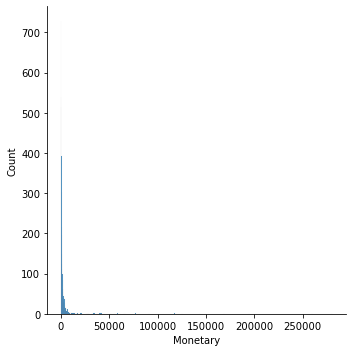

In [62]:
sns.displot(df2['Monetary'])

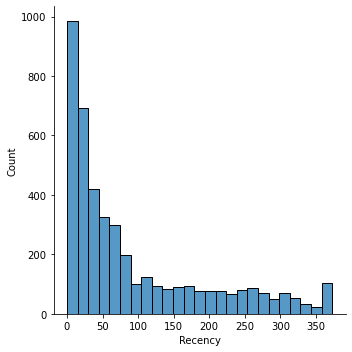

In [63]:
sns.displot(df2['Recency'])

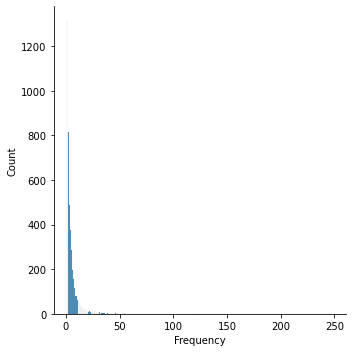

In [64]:
sns.displot(df2['Frequency'])

In [65]:
for i in df2.columns:
    print(i,':',df2[i].skew())

CustomerID : 0.0009180495309383505
Monetary : 19.393929357579932
Recency : 1.249369730991279
Frequency : 11.412273584376694


***Observation:***
- Monetary and Frequency values are highly positively skewed.
- Recency is also positively skewed.
- This indicates that most of the expensive purchases are done by only top maybe 1% percent of customers.
- Similarly frequent buyers are also in top 1%. 

#### Lets check with some graph and numbers

### Monetary

AxesSubplot(0.125,0.125;0.775x0.755)


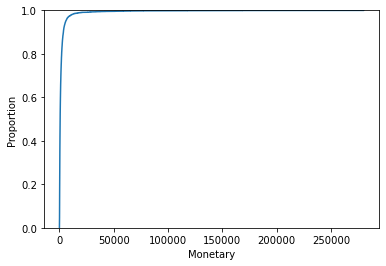

In [66]:
print(sns.ecdfplot(df2.Monetary))

We can observe that there are heavy outliers in the dataset which are skewing the data towards right.

In [67]:
print('Numerical description of Column Monetary:\n',df2.Monetary.describe())

Numerical description of Column Monetary:
 count      4372.000000
mean       2038.290920
std        8956.019171
min           0.000000
25%         303.602500
50%         665.315000
75%        1652.790000
max      280206.020000
Name: Monetary, dtype: float64


In [68]:
df2.Monetary.quantile([0.65,0.98,0.998]) # Population quantile

0.650     1110.36700
0.980    11065.23180
0.998    78174.63992
Name: Monetary, dtype: float64

***Reasoning***
- We will consider the 65% of least spenders as an average buyer.
- Then the next 33% as above average buyers. These buyers can be the one who occasionly bought an expensive object.
- The next 2% are segregated into our top class customers and VIP customers respectively. Both of these groups have spent sufficient sum of money. 

### Recency

<AxesSubplot:xlabel='Recency', ylabel='Proportion'>

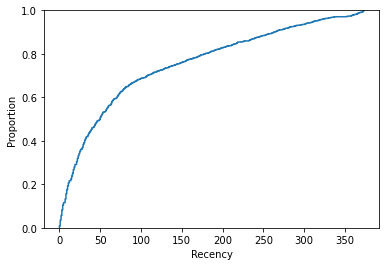

In [69]:
sns.ecdfplot(df2.Recency)

In [70]:
df2.Recency.describe()

count    4372.000000
mean       91.581199
std       100.772139
min         0.000000
25%        16.000000
50%        50.000000
75%       143.000000
max       373.000000
Name: Recency, dtype: float64

In [73]:
df2.Recency.quantile([0.48,0.68,0.85])

0.48     45.0
0.68     96.0
0.85    218.0
Name: Recency, dtype: float64

***Reasoning***
- 48% of population visit the store in 45 days before or lesser. Maybe they are our average monthly buyers. We should target this population as they can be our repetetive loyal customers.
- We can take second quantile at next 20% of population. These can be our infrequent buyers. Buying quaterly basis.
- The third quantile consisting of 17%  of population can be made of buyers who are visting very less. These customers can be transition phase. They may be visting other stores. We can provide them with incentive to check if they get converted.
- Finally, 15% of the customers are the one's who have not made purchase in more than 6 months. This can mean that they can be one time buyer, have mostly relocated or visits different stores now. 

In [74]:
df3=df2.copy()

### Frequency

<AxesSubplot:xlabel='Frequency', ylabel='Proportion'>

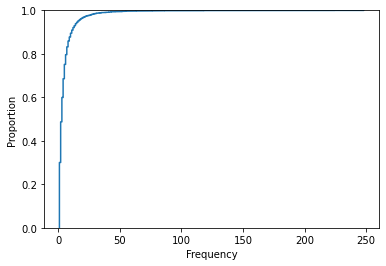

In [75]:
sns.ecdfplot(df2.Frequency)

In [76]:
df2.Frequency.describe()

count    4372.000000
mean        5.075480
std         9.338754
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       248.000000
Name: Frequency, dtype: float64

In [77]:
df2.Frequency.quantile([0.8,0.98,0.998])

0.800     7.000
0.980    27.000
0.998    78.032
Name: Frequency, dtype: float64

***Reasoning***
- 80% of population are the most infrequent buyers.
- The next 18% of buyers can be the one who purchase less than 27 times in a year.
- The next 1.8% percent have made purchased more than 27 times in a year span. 
- Final 0.2% of buyers are the ones which have purchased at modt frequently. More than 75 times in year.

In [ ]:
# rec = [0.3,0.55,0.75]

In [78]:
monetary_quantile = [0.65,0.98,0.998]
recency_quantile = [0.48,0.68,0.85]
frequency_quantile = [0.8,0.98,0.998]

In [79]:
# fucntion for monetary and frequency scoring
def mfScoring(x,y,z):

    if x <= df2[z].quantile(y[0]):
        return 1
    elif x <= df2[z].quantile(y[1]):
        return 2
    elif x <= df2[z].quantile(y[2]):
        return 3
    else:
        return 4

In [80]:
# fucntion for recency scoring
def rScoring(x,y,z):
        
    if x <= df2[z].quantile(y[0]):
        return 4
    elif x <= df2[z].quantile(y[1]):
        return 3
    elif x <= df2[z].quantile(y[2]):
        return 2
    else:
        return 1

In [81]:
df2['R'] = df2.Recency.apply(lambda x: rScoring(x, y=recency_quantile,z='Recency'))
df2['M'] = df2.Monetary.apply(lambda x: mfScoring(x,y=monetary_quantile,z='Monetary'))
df2['F'] = df2.Frequency.apply(lambda x: mfScoring(x,y=frequency_quantile,z='Frequency'))

In [82]:
df2

,CustomerID,Monetary,Recency,Frequency,R,M,F
0,17850.0,5391.21,302,35,1,2,3
1,13047.0,3237.54,31,18,4,2,2
2,12583.0,7281.38,2,18,4,2,2
3,13748.0,948.25,95,5,3,1,1
4,15100.0,876.00,330,6,1,1,1
...,...,...,...,...,...,...,...
4367,15369.0,0.00,144,1,2,1,1
4368,13154.0,0.00,144,1,2,1,1
4369,17065.0,0.00,143,1,2,1,1
4370,16428.0,0.00,81,1,3,1,1


In [83]:
# Total RFM score for a customer
df2['RFM_Sum'] = df2[['R','F','M']].sum(axis=1)

In [84]:
df2.head(2)

,CustomerID,Monetary,Recency,Frequency,R,M,F,RFM_Sum
0,17850.0,5391.21,302,35,1,2,3,6
1,13047.0,3237.54,31,18,4,2,2,8


In [85]:
df2.RFM_Sum.value_counts() # Number of customers as per their RFM score 

6     1229
5      713
4      640
3      610
7      551
8      519
9       60
10      36
11      13
12       1
Name: RFM_Sum, dtype: int64

In [86]:
loyalty_labels = ['Bronze','Silver','Gold', 'Platinum'] # Loyalty labels in ascending order
score_cut = pd.qcut(df2.RFM_Sum,q=4,labels=loyalty_labels)
score_cut # Segregating customers into 4 divisions based on their loyalty score

0         Silver
1       Platinum
2       Platinum
3         Silver
4         Bronze
          ...   
4367      Bronze
4368      Bronze
4369      Bronze
4370      Silver
4371      Silver
Name: RFM_Sum, Length: 4372, dtype: category
Categories (4, object): ['Bronze' < 'Silver' < 'Gold' < 'Platinum']

In [87]:
df2['LoyaltyLabel'] = score_cut.values

In [88]:
df2.head(2)

,CustomerID,Monetary,Recency,Frequency,R,M,F,RFM_Sum,LoyaltyLabel
0,17850.0,5391.21,302,35,1,2,3,6,Silver
1,13047.0,3237.54,31,18,4,2,2,8,Platinum


In [89]:
loyalty_values = df2.LoyaltyLabel.value_counts()
loyalty_values

Silver      1942
Bronze      1250
Platinum     629
Gold         551
Name: LoyaltyLabel, dtype: int64

In [90]:
import matplotlib.style as style
style.use('fivethirtyeight')

<AxesSubplot:>

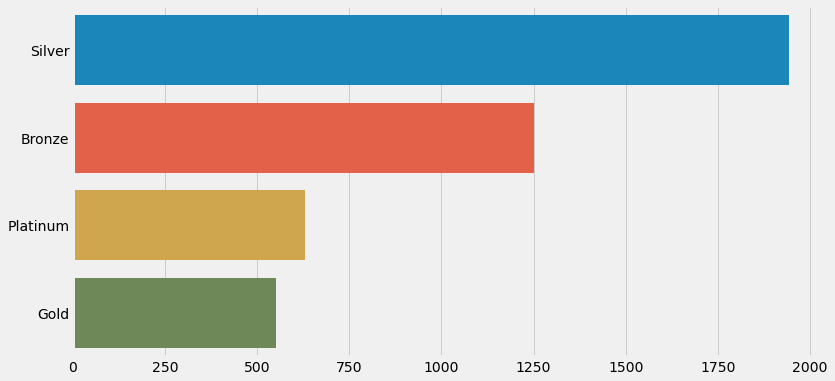

In [91]:
plt.figure(figsize=(12,6))
sns.barplot(data=df2,x=loyalty_values.values,y=loyalty_values.index,
           order=loyalty_values.sort_values(ascending=False).index,)

<AxesSubplot:xlabel='Frequency', ylabel='RFM_Sum'>

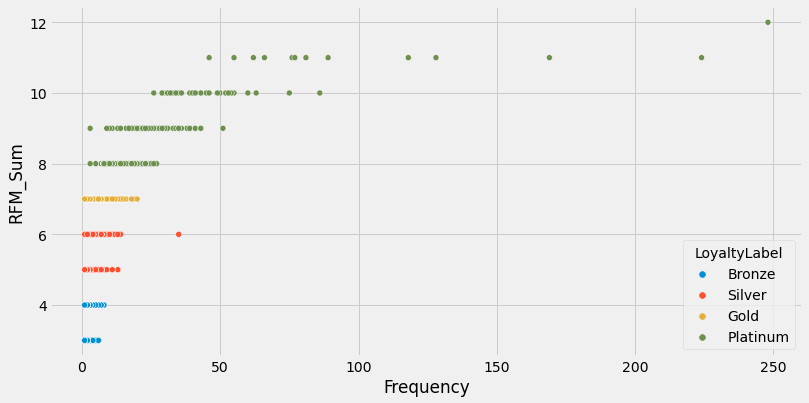

In [92]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df2,x='Frequency',y='RFM_Sum',hue='LoyaltyLabel')

<AxesSubplot:xlabel='Monetary', ylabel='RFM_Sum'>

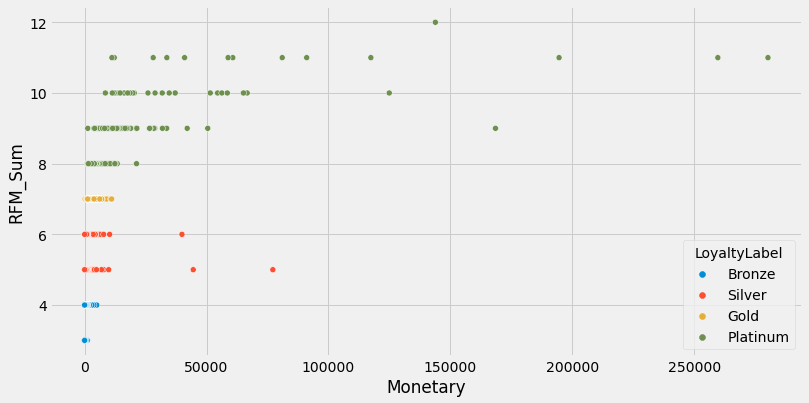

In [93]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df2,x='Monetary',y='RFM_Sum',hue='LoyaltyLabel')

<AxesSubplot:xlabel='Recency', ylabel='RFM_Sum'>

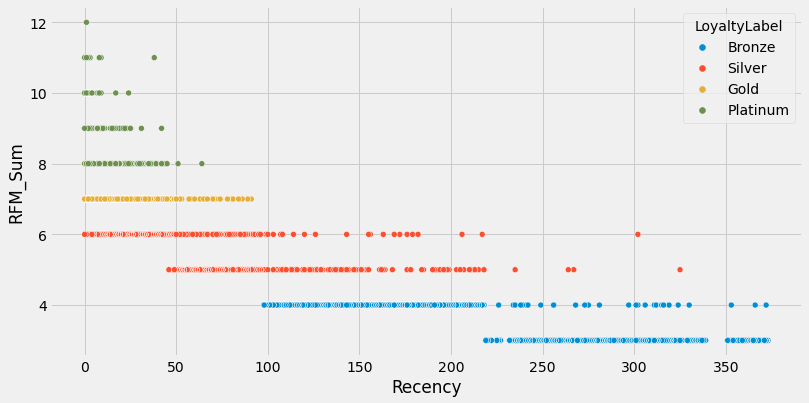

In [94]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df2,x='Recency',y='RFM_Sum',hue='LoyaltyLabel')

# Creating segements

In [95]:
# Creating RFM ID
df2['RFM_ID'] = df2.R.map(str) + df2.F.map(str) + df2.M.map(str)

In [96]:
df2.head()

,CustomerID,Monetary,Recency,Frequency,R,M,F,RFM_Sum,LoyaltyLabel,RFM_ID
0,17850.0,5391.21,302,35,1,2,3,6,Silver,132
1,13047.0,3237.54,31,18,4,2,2,8,Platinum,422
2,12583.0,7281.38,2,18,4,2,2,8,Platinum,422
3,13748.0,948.25,95,5,3,1,1,5,Silver,311
4,15100.0,876.00,330,6,1,1,1,3,Bronze,111


**Customer Segment descriptions:**
1. Inactive or Passerby customers - Customers who are not after anything in particular. only buy what might catch their attention.
2. Promising or Loyal customers - Customers who shop regularly and love this shopping mall
3. New customers - Customers who enjoy their last visit to shop and may come back if they find out more about what this mall has to offer
4. Out-of-town customers or sleeping  - They were once loyal customers, but they move to new place and find a closer shopping mall
5. Students - Customers who visit the store often but they dont spend much
6. Cant loose or Dissatisfied customers - They spend a lot on shopping, but the previous purchase didnt suit them
7. At risk: At risk of losing 
7. Nurture or Soon-to-be loyal customers - They are 'soon-to-be' loyal customers if the previous purchase suited them and the mall catches their attention

In [97]:
# creating a segment map for classifying customers on basis of above criteria
seg_map = {
    r'[1][1-2][1-3]': 'Inactive or Passerby',
    r'[3-4][3-4][2-4]': 'Loyal',
    r'[4][1-2][1-3]': 'New',
    r'[1-2][2-4][2-4]': 'Out of Town',
    r'[2-4][1-3][1]': 'Students',
    r'[1-3][1-4][3-4]': 'Cant Loose or Dissatisfied',
    r'[1-2][2-3][2-4]': 'At-Risk',
    r'[2-4][1-2][2-4]':'Nurture'
    
}

In [98]:
# Creating segments based on above Customer segementation

In [99]:
df2.CustomerID.count()

4372

In [100]:
df2['Customer_Segment'] = df2.RFM_ID.replace(seg_map,regex=True)

In [101]:
df2.Customer_Segment.value_counts()

New                           2036
Students                      1216
Inactive or Passerby           644
Nurture                        367
Loyal                           80
Out of Town                     25
Cant Loose or Dissatisfied       4
Name: Customer_Segment, dtype: int64

In [102]:
df2

,CustomerID,Monetary,Recency,Frequency,R,M,F,RFM_Sum,LoyaltyLabel,RFM_ID,Customer_Segment
0,17850.0,5391.21,302,35,1,2,3,6,Silver,132,Out of Town
1,13047.0,3237.54,31,18,4,2,2,8,Platinum,422,New
2,12583.0,7281.38,2,18,4,2,2,8,Platinum,422,New
3,13748.0,948.25,95,5,3,1,1,5,Silver,311,Students
4,15100.0,876.00,330,6,1,1,1,3,Bronze,111,Inactive or Passerby
...,...,...,...,...,...,...,...,...,...,...,...
4367,15369.0,0.00,144,1,2,1,1,4,Bronze,211,Students
4368,13154.0,0.00,144,1,2,1,1,4,Bronze,211,Students
4369,17065.0,0.00,143,1,2,1,1,4,Bronze,211,Students
4370,16428.0,0.00,81,1,3,1,1,5,Silver,311,Students


In [103]:
style.use('fivethirtyeight')

Text(0.5, 0, 'Number of Customers')

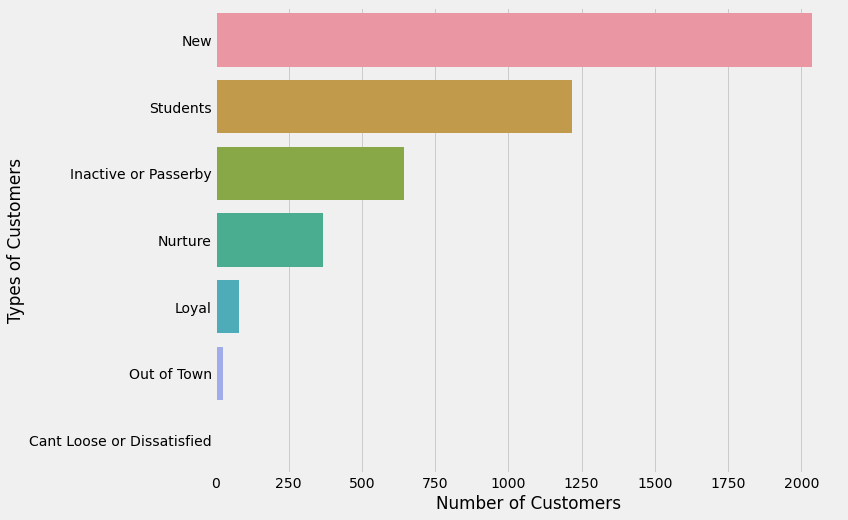

In [104]:
plt.figure(figsize=(10,8))
sns.barplot(data=df2,y=df2.Customer_Segment.value_counts().index,x=df2.Customer_Segment.value_counts().values)
plt.ylabel('Types of Customers')
plt.xlabel('Number of Customers')

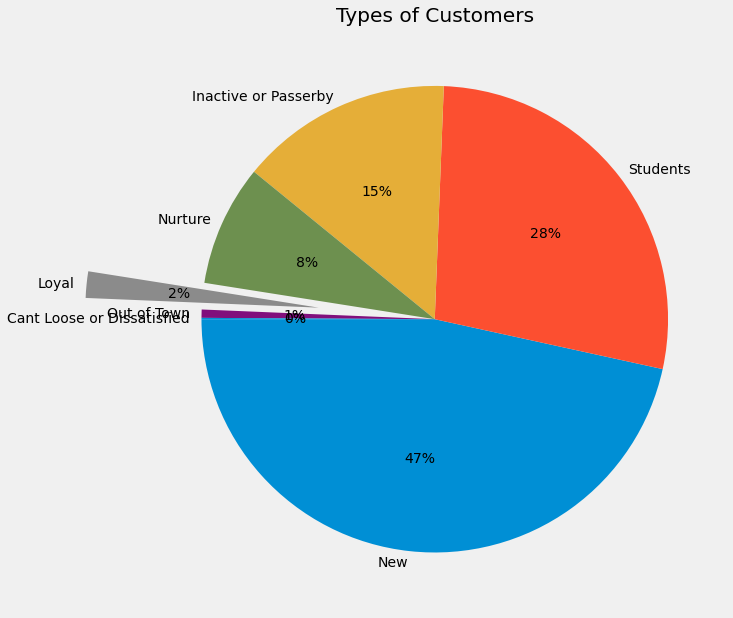

In [105]:
plt.figure(figsize=(15,10))
plt.pie(data=df2,x=df2.Customer_Segment.value_counts(),labels=df2.Customer_Segment.value_counts().index,
        autopct= lambda x: '{:.0f}%'.format(x),labeldistance=1.05,startangle=180,explode=(0,0,0,0,0.5,0,0))
plt.title('Types of Customers')
plt.show()

## K Means Clustering

In [106]:
from sklearn.cluster import KMeans

In [107]:
RFMScore = pd.DataFrame(df2['RFM_Sum'])
RFMScore

,RFM_Sum
0,6
1,8
2,8
3,5
4,3
...,...
4367,4
4368,4
4369,4
4370,5


In [108]:
SSE = [] # list of Sum of square

for k in range(1,25):
    km = KMeans(n_clusters=k)
    km.fit(RFMScore)
    SSE.append(km.inertia_)

C:\Users\Shenoy\AppData\Local\Temp\ipykernel_2132\1717772868.py:5: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  km.fit(RFMScore)
C:\Users\Shenoy\AppData\Local\Temp\ipykernel_2132\1717772868.py:5: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  km.fit(RFMScore)
C:\Users\Shenoy\AppData\Local\Temp\ipykernel_2132\1717772868.py:5: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  km.fit(RFMScore)
C:\Users\Shenoy\AppData\Local\Temp\ipykernel_2132\1717772868.py:5: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  km.fit(RFMScore)
C:\Users\Shenoy\AppData\Local\Temp\ipykernel_2132\1717772868.py:5: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clu

In [109]:
Error_km = pd.DataFrame({'No. of Clusters': range (1,25), 'SSE': SSE})

In [110]:
Error_km

,No. of Clusters,SSE
0,1,1.209346e+04
1,2,3.787616e+03
2,3,1.531734e+03
3,4,1.080510e+03
4,5,6.006316e+02
5,6,2.883116e+02
6,7,5.859091e+01
7,8,1.250000e+01
8,9,9.285714e-01
9,10,4.410620e-26


In [111]:
Error_km[Error_km.SSE == Error_km.SSE.min()]

,No. of Clusters,SSE
9,10,4.410620e-26


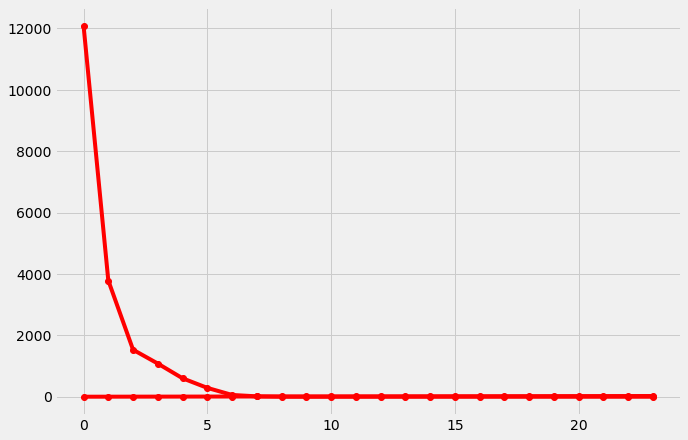

In [112]:
plt.figure(figsize=(10,7))
plt.plot(Error_km.iloc[:43,:],marker='o',color='r')

In [113]:
from yellowbrick.cluster import KElbowVisualizer

D:\Siddhesh\Installers\Installed\Anaconda\lib\site-packages\yellowbrick\cluster\elbow.py:339: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
D:\Siddhesh\Installers\Installed\Anaconda\lib\site-packages\yellowbrick\cluster\elbow.py:339: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
D:\Siddhesh\Installers\Installed\Anaconda\lib\site-packages\yellowbrick\cluster\elbow.py:339: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
D:\Siddhesh\Installers\Installed\Anaconda\lib\site-packages\yellowbrick\cluster\elbow.py:339: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  self.est

D:\Siddhesh\Installers\Installed\Anaconda\lib\site-packages\yellowbrick\cluster\elbow.py:339: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (44). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)


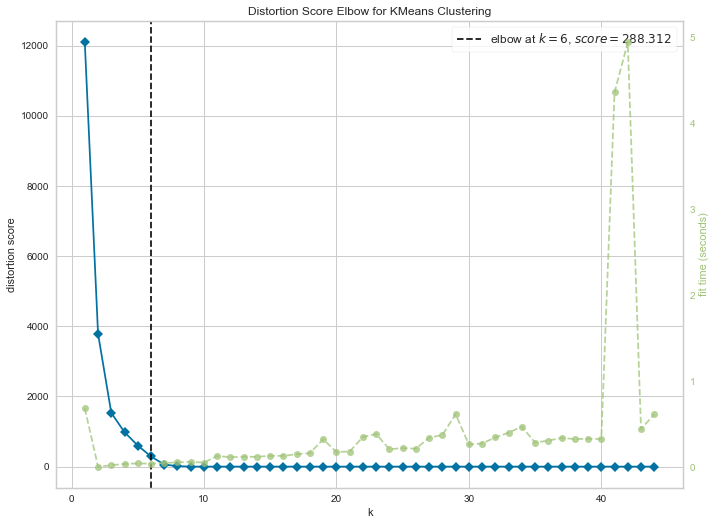

In [114]:
plt.figure(figsize=(10,8))
model = KMeans()
visualiser = KElbowVisualizer(estimator=model,k=range(1,45))
visualiser.fit(RFMScore)
visualiser.show()
plt.show()

In [115]:
Error_km[Error_km.SSE==Error_km.SSE.min()]

,No. of Clusters,SSE
9,10,4.410620e-26


##### We obtained lowest sum of squared error at 10 nos. of clusters. Exact 10 i.e. total number of unique combinations for summing RFM Score.

In [129]:
df2.RFM_Sum.nunique()

10

In [130]:
km_final = KMeans(n_clusters=4,max_iter=300,random_state=42)
km_final.fit(RFMScore)

KMeans(n_clusters=4, random_state=42)

In [131]:
km_final.labels_

array([0, 2, 2, ..., 1, 3, 3])

In [132]:
df2['Cluster'] = km_final.labels_
df2

,CustomerID,Monetary,Recency,Frequency,R,M,F,RFM_Sum,LoyaltyLabel,RFM_ID,Customer_Segment,Cluster
0,17850.0,5391.21,302,35,1,2,3,6,Silver,132,Out of Town,0
1,13047.0,3237.54,31,18,4,2,2,8,Platinum,422,New,2
2,12583.0,7281.38,2,18,4,2,2,8,Platinum,422,New,2
3,13748.0,948.25,95,5,3,1,1,5,Silver,311,Students,3
4,15100.0,876.00,330,6,1,1,1,3,Bronze,111,Inactive or Passerby,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4367,15369.0,0.00,144,1,2,1,1,4,Bronze,211,Students,1
4368,13154.0,0.00,144,1,2,1,1,4,Bronze,211,Students,1
4369,17065.0,0.00,143,1,2,1,1,4,Bronze,211,Students,1
4370,16428.0,0.00,81,1,3,1,1,5,Silver,311,Students,3


In [133]:
df2.Cluster.value_counts()

0    1780
1    1250
3     713
2     629
Name: Cluster, dtype: int64

<AxesSubplot:xlabel='Recency', ylabel='RFM_Sum'>

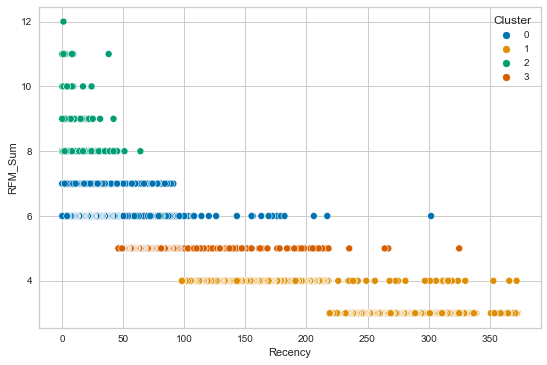

In [134]:
sns.scatterplot(data=df2,x='Recency',y='RFM_Sum',hue='Cluster',palette='colorblind')

<AxesSubplot:xlabel='Frequency', ylabel='RFM_Sum'>

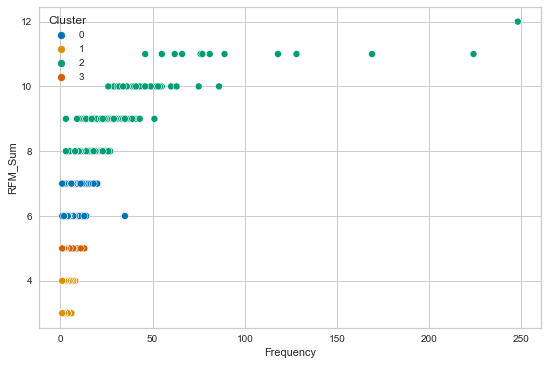

In [135]:
sns.scatterplot(data=df2,x='Frequency',y='RFM_Sum',hue='Cluster',palette='colorblind')

### Evaluating the Cluster

In [136]:
km_final.labels_

array([0, 2, 2, ..., 1, 3, 3])

In [137]:
pd.DataFrame(km_final.labels_).value_counts()

0    1780
1    1250
3     713
2     629
dtype: int64

In [138]:
RFMScore.value_counts()

RFM_Sum
6          1229
5           713
4           640
3           610
7           551
8           519
9            60
10           36
11           13
12            1
dtype: int64

In [139]:
from sklearn.metrics import silhouette_score, silhouette_samples
silhouette_score(RFMScore,km_final.labels_)

0.7074322500271227

We have obtained a Silhouette score greater than 0.5.
Thus, our four clusters are good enough. We can ofcourse improve by creating total 6 clusters.
Since our Silhouette score will increase to 95%, as seen below.

In [140]:
km_5 = KMeans(n_clusters=6,random_state=42,max_iter=108)
km_5.fit(RFMScore)
km_5.labels_

array([2, 0, 0, ..., 1, 3, 3])

In [141]:
silhouette_score(RFMScore,km_5.labels_)

0.9534750307399141

### Goal 2:
#### Predict the sales trend 
1. when is the sales highest (month/season/day)
2. when is the rush hour?
3. when the rush as per timing (morning,afternoon,evening )

In [142]:
df3 = df1.copy()

In [143]:
df1['Month'] = df1.InvoiceDate.dt.month
df1['Day'] = df1.InvoiceDate.dt.day_name() # Creating columns of Month and Day

In [144]:
df1

,InvoiceNo,Total_Amt,InvoiceDate,CustomerID,Month,Day
0,536365,139.12,2010-12-01 08:26:00,17850.0,12,Wednesday
1,536366,22.20,2010-12-01 08:28:00,17850.0,12,Wednesday
2,536367,278.73,2010-12-01 08:34:00,13047.0,12,Wednesday
3,536368,70.05,2010-12-01 08:34:00,13047.0,12,Wednesday
4,536369,17.85,2010-12-01 08:35:00,13047.0,12,Wednesday
...,...,...,...,...,...,...
22185,C581484,0.00,2011-12-09 09:27:00,16446.0,12,Friday
22186,C581490,0.00,2011-12-09 09:57:00,14397.0,12,Friday
22187,C581499,0.00,2011-12-09 10:28:00,15498.0,12,Friday
22188,C581568,0.00,2011-12-09 11:57:00,15311.0,12,Friday


In [145]:
def season(x):
    if x in [12,1,2]:
        return 'Winter'
    elif x in [3,4,5]:
        return 'Spring'
    elif x in [6,7,8]:
        return 'Summer'
    else:
        return'Autumn'

In [146]:
df1['Season'] = df1.Month.apply(season) # Segregating seasons

In [147]:
df1.head()

,InvoiceNo,Total_Amt,InvoiceDate,CustomerID,Month,Day,Season
0,536365,139.12,2010-12-01 08:26:00,17850.0,12,Wednesday,Winter
1,536366,22.20,2010-12-01 08:28:00,17850.0,12,Wednesday,Winter
2,536367,278.73,2010-12-01 08:34:00,13047.0,12,Wednesday,Winter
3,536368,70.05,2010-12-01 08:34:00,13047.0,12,Wednesday,Winter
4,536369,17.85,2010-12-01 08:35:00,13047.0,12,Wednesday,Winter


### When is the sales highest by: Day

In [148]:
day_sales_trend = df1.groupby('Day').apply(lambda x: x['Total_Amt'].sum())

In [149]:
style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [150]:
style.use('seaborn-colorblind')

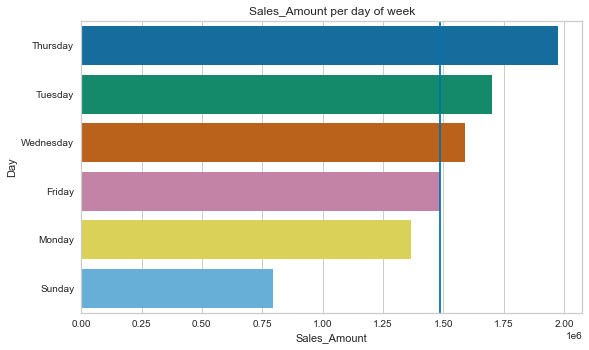

In [151]:
plt.figure(figsize=(8,5))
sns.barplot(y=day_sales_trend.index,x=day_sales_trend.values,order=day_sales_trend.sort_values(ascending=False).index)
plt.xlabel('Sales_Amount')
plt.title('Sales_Amount per day of week')
plt.axvline(day_sales_trend.mean())

##### Maximum sales occur on Thursday. Let's check Customer trend per day of week

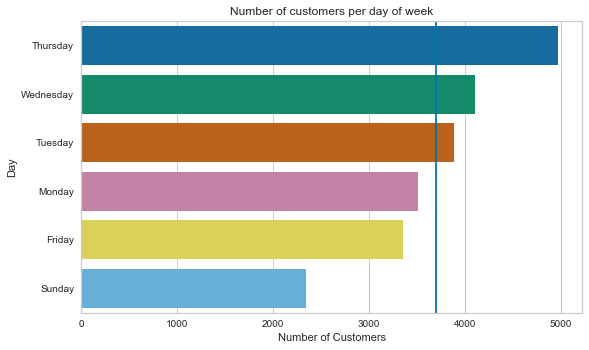

In [152]:
plt.figure(figsize=(8,5))
sns.countplot(y=df1.Day,order=df1.Day.value_counts().sort_values(ascending=False).index)
plt.xlabel('Number of Customers')
plt.title('Number of customers per day of week')
plt.axvline(df1.Day.value_counts().mean())
plt.show()

##### The busiest and most important day is Thursday, followed by Tuesday / Wednesday, and Monday/ Friday.The least customers come on Sunday, which seems counter intiutive. Since most people have holiday on Sunday and should visit mall for shopping on that day.

### When is the sales highest by: Month

In [153]:
style.use('fivethirtyeight')

In [154]:
month_sales_trend = df1.groupby('Month').apply(lambda x: x['Total_Amt'].sum())

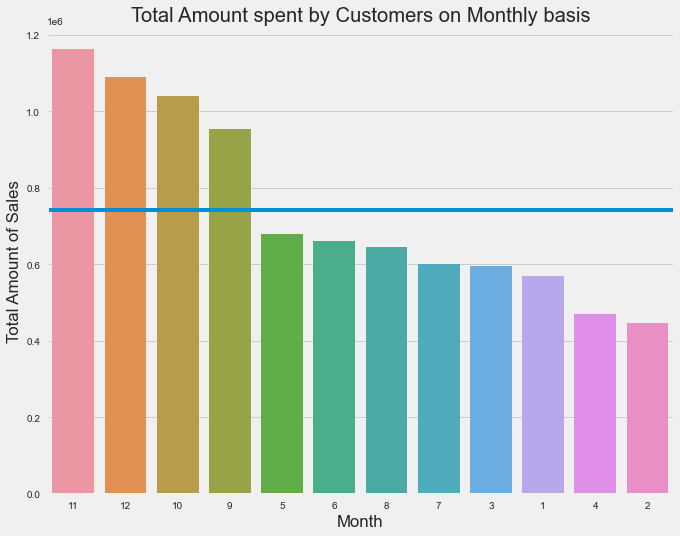

In [155]:
plt.figure(figsize=(10,8))
sns.barplot(y=month_sales_trend.values,
            x=month_sales_trend.index,order = month_sales_trend.sort_values(ascending=False).index)
plt.ylabel('Total Amount of Sales')
plt.title('Total Amount spent by Customers on Monthly basis')
plt.axhline(month_sales_trend.mean())
plt.show()

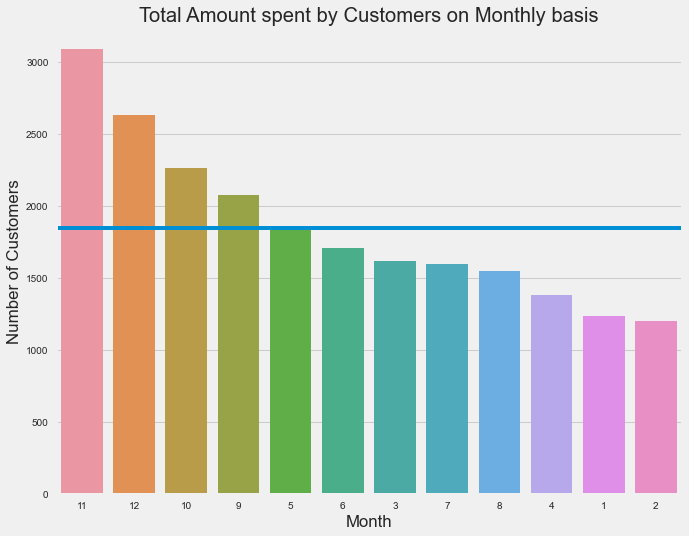

In [156]:
plt.figure(figsize=(10,8))
sns.barplot(y=df1.Month.value_counts().values,x=df1.Month.value_counts().index,
            order=df1.Month.value_counts().sort_values(ascending=False).index)
plt.ylabel('Number of Customers')
plt.xlabel('Month')
plt.title('Total Amount spent by Customers on Monthly basis')
plt.axhline(df1.Month.value_counts().mean())
plt.show()

We can clearly infer that Months of November, December and October have most sales and customer visit.
Maybe because these are the months where people are approaching Winters and also festival season in Christmas.

Whereas the Sales drop below average after festival months from January till July.

### When is the sales highest by: Season

In [157]:
df1

,InvoiceNo,Total_Amt,InvoiceDate,CustomerID,Month,Day,Season
0,536365,139.12,2010-12-01 08:26:00,17850.0,12,Wednesday,Winter
1,536366,22.20,2010-12-01 08:28:00,17850.0,12,Wednesday,Winter
2,536367,278.73,2010-12-01 08:34:00,13047.0,12,Wednesday,Winter
3,536368,70.05,2010-12-01 08:34:00,13047.0,12,Wednesday,Winter
4,536369,17.85,2010-12-01 08:35:00,13047.0,12,Wednesday,Winter
...,...,...,...,...,...,...,...
22185,C581484,0.00,2011-12-09 09:27:00,16446.0,12,Friday,Winter
22186,C581490,0.00,2011-12-09 09:57:00,14397.0,12,Friday,Winter
22187,C581499,0.00,2011-12-09 10:28:00,15498.0,12,Friday,Winter
22188,C581568,0.00,2011-12-09 11:57:00,15311.0,12,Friday,Winter


In [158]:
season_sales_trend=df1.groupby('Season').apply(lambda x: x['Total_Amt'].sum())

In [159]:
season_sales_trend

Season
Autumn    3153974.552
Spring    1743295.681
Summer    1906648.601
Winter    2107489.070
dtype: float64

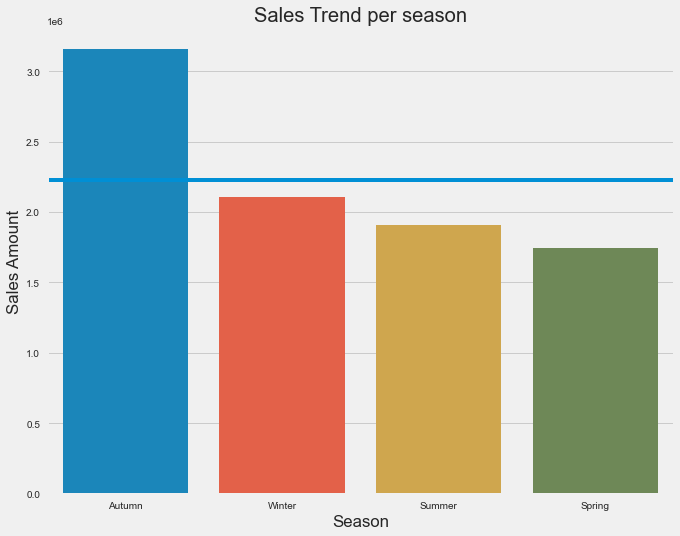

In [160]:
plt.figure(figsize=(10,8))

sns.barplot(y=season_sales_trend.values,x=season_sales_trend.index,
            order=season_sales_trend.sort_values(ascending=False).index)
plt.title('Sales Trend per season')
plt.ylabel('Sales Amount')
plt.axhline(season_sales_trend.mean())

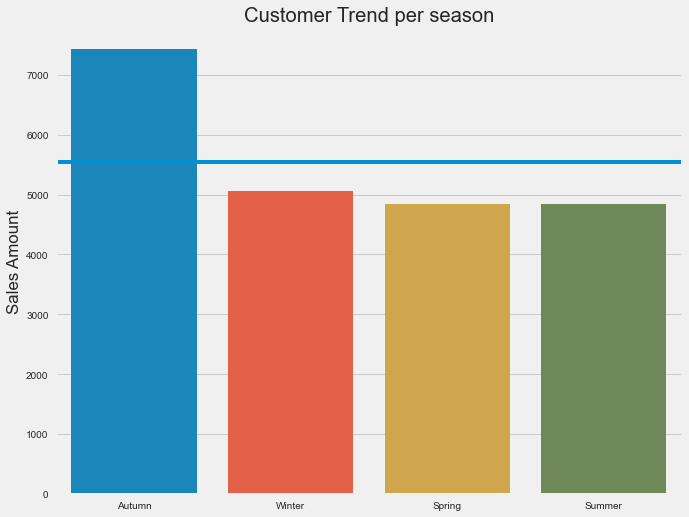

In [161]:
# Customers per season
plt.figure(figsize=(10,8))

sns.barplot(y=df1.Season.value_counts().values,x=df1.Season.value_counts().index,
            order=df1.Season.value_counts().sort_values(ascending=False).index)
plt.title('Customer Trend per season')
plt.ylabel('Sales Amount')
plt.axhline(df1.Season.value_counts().mean())
plt.show()

In [162]:
df1[df1.Season == 'Autumn']['Month'].value_counts()

11    3086
10    2263
9     2078
Name: Month, dtype: int64

We can clearly infer that the sales shoot up in season of autumn. Maybe because people are hoarding stuff before winter. when stores could be shut because of snow fall. 

 ### 2.when is the rush hour?

In [163]:
df1.InvoiceDate.dt.hour

0         8
1         8
2         8
3         8
4         8
         ..
22185     9
22186     9
22187    10
22188    11
22189    11
Name: InvoiceDate, Length: 22190, dtype: int64

In [164]:
df4 = df1.copy()

In [165]:
df1['Hour'] = df1.InvoiceDate.dt.hour

In [166]:
df1.head(2)

,InvoiceNo,Total_Amt,InvoiceDate,CustomerID,Month,Day,Season,Hour
0,536365,139.12,2010-12-01 08:26:00,17850.0,12,Wednesday,Winter,8
1,536366,22.20,2010-12-01 08:28:00,17850.0,12,Wednesday,Winter,8


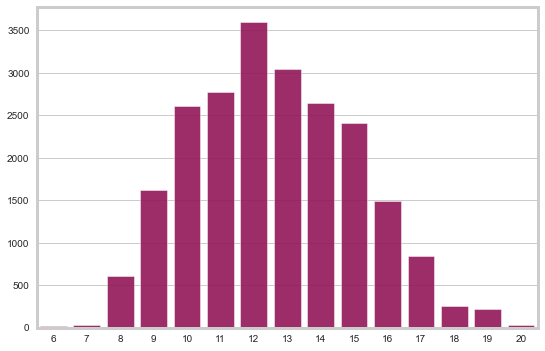

In [167]:
sns.set_style('whitegrid')

sns.barplot(y=df1.Hour.value_counts().values,x=df1.Hour.value_counts().index,color='m',alpha=0.9)
plt.show()

We can see that the distribution is normally distributed with peak at 3400 people at about 12 pm. So, the rush hour is at 11am to 2pm with peak at 12pm.

Segregating this futher to in times of parts of a day.

 #### 3.when the rush as per timing (morning,afternoon,evening )

In [168]:
# Dividing day into 3 parts, Morning, Afternoon and Evening

In [169]:
df1.Hour.value_counts().index.sort_values()

Int64Index([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int64')

In [170]:
morning = [6, 7, 8, 9, 10,11,12]
afternoon = [13, 14, 15, 16, 17, 18]
evening = [19, 20]

In [171]:
def day_part(x):
    if x in morning:
        return 'Morning'
    elif x in afternoon:
        return 'Afternoon'
    else:
        return 'Evening'

In [172]:
df1['Part_of_Day'] = df1.Hour.apply(day_part)

In [173]:
df1.Part_of_Day.value_counts()

Morning      11262
Afternoon    10683
Evening        245
Name: Part_of_Day, dtype: int64

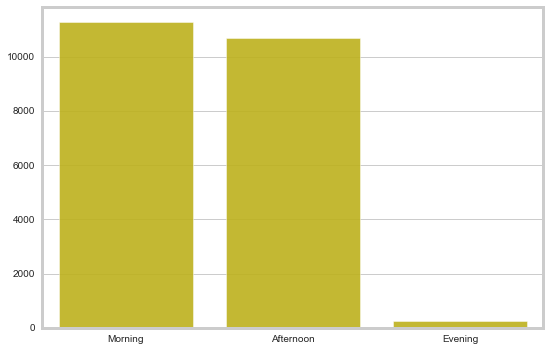

In [174]:
sns.barplot(y=df1.Part_of_Day.value_counts().values,x=df1.Part_of_Day.value_counts().index,color='y',alpha=0.9)
plt.show()

We can infer that both Morning and Afternoon are equally busy. So rather than dividing day into traditional sense. We should look at the hours graph and adjust the staff accordingly.

### Goal 3: Highest sale items top 10 or 20

In [175]:
df4 = df1.copy()

In [176]:
df5 = customer.copy()

In [177]:
df5.drop(['StockCode','lower','Country'],axis = 1,inplace=True)
df5.head()

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0


Here we will not drop CustomerID missing values since we need to check about total items sold and revenue generated.

In [178]:
def zero_rep(x):
    if x<0:
        return 0
    else:
        return x
# a fucntion that returns zero if value of quantity is in negative

In [179]:
df5['Quantity'] = df5['Quantity'].apply(zero_rep)
df5.Quantity[df5.Quantity<0].sum()

0

In [180]:
df5.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,10.446368,155.292426,0.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [181]:
df5[df5.UnitPrice<0]['UnitPrice'].count()
# Unit Price is negative of some items. We will check the number of such occurances

2

Since only 2 no. of occurances are there. We will drop these rows.

In [182]:
df5.drop(df5[df5.UnitPrice<0].index, inplace = True, axis = 0)

In [183]:
df5[df5.UnitPrice<0]['UnitPrice'].count()

0

In [184]:
df5.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541907.0,10.446403,155.292711,0.0,1.00,3.00,10.00,80995.0
UnitPrice,541907.0,4.651957,94.395447,0.0,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.0,13953.00,15152.00,16791.00,18287.0


Now we will not drop customers where value is null since our main aim is to check best selling item

In [185]:
df5.head()

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0


In [186]:
df5['Total_Price'] = df5.Quantity * df5.UnitPrice
df5.head()

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Total_Price
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,15.30
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,20.34


In [187]:
df5.describe()

,Quantity,UnitPrice,CustomerID,Total_Price
count,541907.000000,541907.000000,406829.000000,541907.000000
mean,10.446403,4.651957,15287.690570,19.683607
std,155.292711,94.395447,1713.600303,267.412408
min,0.000000,0.000000,12346.000000,0.000000
25%,1.000000,1.250000,13953.000000,3.400000
50%,3.000000,2.080000,15152.000000,9.750000
75%,10.000000,4.130000,16791.000000,17.400000
max,80995.000000,38970.000000,18287.000000,168469.600000


In [188]:
Item_Price = df5.groupby('Description').apply(lambda x: x['Total_Price'].sum())
Item_Price = Item_Price.sort_values(ascending=False).head(20)

### These are our Top Selling Items on basis of Price:

In [189]:
pd.DataFrame({'Rank':range(1,21),'Item_Name':Item_Price.index,'Total_Amt':Item_Price.values})

,Rank,Item_Name,Total_Amt
0,1,DOTCOM POSTAGE,206248.77
1,2,REGENCY CAKESTAND 3 TIER,174484.74
2,3,"PAPER CRAFT , LITTLE BIRDIE",168469.60
3,4,WHITE HANGING HEART T-LIGHT HOLDER,106292.77
4,5,PARTY BUNTING,99504.33
5,6,JUMBO BAG RED RETROSPOT,94340.05
6,7,MEDIUM CERAMIC TOP STORAGE JAR,81700.92
7,8,Manual,78112.82
8,9,POSTAGE,78101.88
9,10,RABBIT NIGHT LIGHT,66964.99


In [190]:
Item_Qty = df5.groupby('Description').apply(lambda x: x['Quantity'].sum())
Item_Qty = Item_Qty.sort_values(ascending=False).head(20)

### These are our most selling items in terms of quantities sold:

In [191]:
pd.DataFrame({'Rank': range(1,21),'Item_Name':Item_Qty.index,'Total Items Sold': Item_Qty.values})

,Rank,Item_Name,Total Items Sold
0,1,"PAPER CRAFT , LITTLE BIRDIE",80995
1,2,MEDIUM CERAMIC TOP STORAGE JAR,78033
2,3,WORLD WAR 2 GLIDERS ASSTD DESIGNS,55047
3,4,JUMBO BAG RED RETROSPOT,48478
4,5,WHITE HANGING HEART T-LIGHT HOLDER,37895
5,6,POPCORN HOLDER,36761
6,7,ASSORTED COLOUR BIRD ORNAMENT,36461
7,8,PACK OF 72 RETROSPOT CAKE CASES,36419
8,9,RABBIT NIGHT LIGHT,30788
9,10,MINI PAINT SET VINTAGE,26633


### Goal 4: Customer segregation with highest weightage to monetary

Giving high weightage to Monetary we will multiply monetary by 10 and re-caluculate RFM_score make a customer segregation

In [210]:
df7 = df2.copy()

In [211]:
df7.head()

,CustomerID,Monetary,Recency,Frequency,R,M,F,RFM_Sum,LoyaltyLabel,RFM_ID,Customer_Segment,Cluster
0,17850.0,5391.21,302,35,1,2,3,6,Silver,132,Out of Town,0
1,13047.0,3237.54,31,18,4,2,2,8,Platinum,422,New,2
2,12583.0,7281.38,2,18,4,2,2,8,Platinum,422,New,2
3,13748.0,948.25,95,5,3,1,1,5,Silver,311,Students,3
4,15100.0,876.00,330,6,1,1,1,3,Bronze,111,Inactive or Passerby,1


In [212]:
df7['RFM_Sum_Mbasis'] = df7.R + df7.F+ df7.M * 10
# Giving more importance to Monetary parameter we will segregate the customers

In [213]:
df7

,CustomerID,Monetary,Recency,Frequency,R,M,F,RFM_Sum,LoyaltyLabel,RFM_ID,Customer_Segment,Cluster,RFM_Sum_Mbasis
0,17850.0,5391.21,302,35,1,2,3,6,Silver,132,Out of Town,0,24
1,13047.0,3237.54,31,18,4,2,2,8,Platinum,422,New,2,26
2,12583.0,7281.38,2,18,4,2,2,8,Platinum,422,New,2,26
3,13748.0,948.25,95,5,3,1,1,5,Silver,311,Students,3,14
4,15100.0,876.00,330,6,1,1,1,3,Bronze,111,Inactive or Passerby,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4367,15369.0,0.00,144,1,2,1,1,4,Bronze,211,Students,1,13
4368,13154.0,0.00,144,1,2,1,1,4,Bronze,211,Students,1,13
4369,17065.0,0.00,143,1,2,1,1,4,Bronze,211,Students,1,13
4370,16428.0,0.00,81,1,3,1,1,5,Silver,311,Students,3,14


In [214]:
df7.RFM_Sum_Mbasis.describe()

count    4372.000000
mean       17.928637
std         6.109534
min        12.000000
25%        13.000000
50%        15.000000
75%        25.000000
max        48.000000
Name: RFM_Sum_Mbasis, dtype: float64

In [215]:
df7.RFM_Sum_Mbasis.quantile([0.5,0.75,0.96])

0.50    15.0
0.75    25.0
0.96    26.0
Name: RFM_Sum_Mbasis, dtype: float64

In [216]:
quantile_monetary = [0.5,0.75,0.96]

In [217]:
def RFMScore_Mbasis(x,y):
    if x<=df7.RFM_Sum_Mbasis.quantile(y[0]):
        return 'Bronze'
    elif x<=df7.RFM_Sum_Mbasis.quantile(y[1]):
        return 'Silver'
    elif x<=df7.RFM_Sum_Mbasis.quantile(y[2]):
        return 'Gold'
    else:
        return 'Platinum'

In [218]:
df7['MonetaryLabel_2'] = df7.RFM_Sum_Mbasis.apply(lambda x : RFMScore_Mbasis(x,y=quantile_monetary) )

In [219]:
df7.head(5)

,CustomerID,Monetary,Recency,Frequency,R,M,F,RFM_Sum,LoyaltyLabel,RFM_ID,Customer_Segment,Cluster,RFM_Sum_Mbasis,MonetaryLabel_2
0,17850.0,5391.21,302,35,1,2,3,6,Silver,132,Out of Town,0,24,Silver
1,13047.0,3237.54,31,18,4,2,2,8,Platinum,422,New,2,26,Gold
2,12583.0,7281.38,2,18,4,2,2,8,Platinum,422,New,2,26,Gold
3,13748.0,948.25,95,5,3,1,1,5,Silver,311,Students,3,14,Bronze
4,15100.0,876.00,330,6,1,1,1,3,Bronze,111,Inactive or Passerby,1,12,Bronze


In [220]:
(df7.MonetaryLabel_2.value_counts() / df7.MonetaryLabel_2.count())*100

Bronze      64.661482
Silver      20.860018
Gold        11.733760
Platinum     2.744739
Name: MonetaryLabel_2, dtype: float64

We segregated customers into four groups

### We can conclude that:

- ***About 3%*** of our Customers belong ***Platinum*** standard class. They have provided very huge chunk of amount to business.
- ***About 12%*** of customer lies in ***Gold*** category. 
- ***About 21%*** customers belong to ***Silver*** group. They have medium buying capacity.
-***Majority of 64.5%*** of customers belongs to ***Bronze*** group. These customers provide us least business in terms of Money.

Even though we have classifed customers on this basis of money. It's important to futher segregate them on basis of their RFM_ID as many customers may have invested once in a while a big chunck of amount.

So RFM_ID along with Monetary Score forms a good basis for taking decison to provide gift vouchers to customers.